<a href="https://colab.research.google.com/github/Nohalyan/Projetppchem/blob/Enzo/Notebook_WSP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Water Solubility Predisction

This notebook is the core of our Water Solubility Prediction project. This is where we collected, sorted and cleaned the data, as well as selecting, testing and training our prediction models.

This notebook is divided into sections:
1. Modules and Libraries
2. Solubility Data *(optional)*
3. Calculation of RDkit Molecular Descriptors *(optional)*
4. Training and Validation set
5. Select Machine Learning Models
6. Fine-tuning
7. Models for training and test data

Sections 2 and 3 are optional, as sorted and cleaned data can be retrieved directly in section 4.1.


## 1 Import Relevant Modules and Libraries

We will start by importing the modules and libraries essential for this project.


In [1]:
# Install all libraries used in this project
!pip install pathlib numpy pandas rdkit matplotlib scikit-learn lightgbm lazypredict tqdm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.9/34.9 MB 21.1 MB/s eta 0:00:00


In [2]:
# Install all modules used in this project
from pathlib import Path

import warnings
warnings.filterwarnings("ignore")

import numpy as np

import pandas as pd

from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit import Chem
from rdkit.Chem import Descriptors
from rdkit.ML.Descriptors import MoleculeDescriptors

from matplotlib import pyplot as plt
import matplotlib.patches as mpatches

import seaborn as sn

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_squared_error

from lightgbm import LGBMRegressor

from sklearn.ensemble import RandomForestRegressor
from sklearn.impute import SimpleImputer

import lazypredict
from lazypredict.Supervised import LazyRegressor

from tqdm import tqdm

from google.colab import files

from scipy import stats

# 2. Solubility Data

## 2.1 Let's get the Solubility Data

Firstly, we will acquire solubility data from gashawmg's repository, accessible at https://github.com/gashawmg. Subsequently, we will conduct an exploratory data analysis on the acquired dataset.

In [3]:
!wget https://raw.githubusercontent.com/Nohalyan/Projetppchem/main/Data/Data_Solubility.csv

--2024-05-07 19:12:56--  https://raw.githubusercontent.com/Nohalyan/Projetppchem/main/Data/Data_Solubility.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.110.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 987356 (964K) [text/plain]
Saving to: ‘Data_Solubility.csv’

Data_Solubility.csv 100%[===================>] 964.21K  --.-KB/s    in 0.06s   

2024-05-07 19:12:56 (17.0 MB/s) - ‘Data_Solubility.csv’ saved [987356/987356]



Let's open the file ans confirm that it exist.

In [4]:
# Create a Path object for the current directory, in our case /content/
current_directory = Path.cwd()
print("Current Directory:", current_directory.resolve())

file_path = current_directory / "Data_Solubility.csv"

# Reading the contents of the file and check that the file exists
if file_path.exists():
    with file_path.open("r") as file:
        content = file.read()
        print(content)
else:
    print("The file does not exist.")


Streaming output truncated to the last 5000 lines.
C775;CULUWZNBISUWAS-UHFFFAOYSA-N;O=C(Cn1ccnc1[N+](=O)[O-])NCc1ccccc1;-2.8099999;2.0218;260.249
C5854;ADRPZEYTIFWCBC-UHFFFAOYSA-N;FCC(=O)N(c1cccc2c1cccc2)C;-2.809315891;2.7721;217.239
C5855;COVFEVWNJUOYRL-UHFFFAOYSA-N;O=C(c1cc(O)c(c(c1)O)O)Oc1cc(cc(c1O)O)C(=O)O;-2.809189242;1.132;322.224
C5856;VYMMCESYBCZZER-UHFFFAOYSA-N;Cn1c(=O)n(c2ccccc2)c(c(c1=O)N1CCCC1)C;-2.808969554;1.5098;285.341
C5857;HGBLNBBNRORJKI-WCABBAIRSA-N;OC(=O)[C@@H]1N2C(=O)[C@H]([C@H]2SC1(C)C)NC(=O)C1(N)CCCCC1;-2.808365663;1.3088;341.426
C5858;GCZZOZBWAZHCAN-UHFFFAOYSA-N;S=C(Nc1nccs1)Nc1ccccc1;-2.806998312;3.098;235.329
C5859;KVYGGMBOZFWZBQ-UHFFFAOYSA-N;O=C(c1cccnc1)OCc1ccccc1;-2.806025193;2.4386;213.232
C5860;PZCDSVSZCJTGDJ-UHFFFAOYSA-N;COc1cccc(c1)N1CCN(CC1)CC(COc1cccc(c1)C=O)O;-2.804552306;2.0725;370.442
C5861;XPJOIOLIBUKQBN-UHFFFAOYSA-N;ClCCN(C(=O)NC1CCSCC1)N=O;-2.804336155;2.2047;251.734
C5862;BYBUKOLWVLGTJF-UHFFFAOYSA-N;CC(Cc1ccccc1)NNC(=O)c1noc(c1)C;-2.803157411;2

The file use semicicolon as delimiter, so let's open the file and use semicicolon as delimiter:

In [5]:
# Open a file containing descriptors and yield
data_solubility = pd.read_csv("/content/Data_Solubility.csv", delimiter=';')

Now we will check the data see if it is what we want.

In [6]:
data_solubility.shape

(9943, 6)

In [7]:
data_solubility.head()

,Compound ID,InChIKey,SMILES,logS,logP,MW
0,C1711,ACTIUHUUMQJHFO-UPTCCGCDSA-N,COC1=C(OC)C(=O)C(=C(C1=O)C/C=C(/CC/C=C(/CC/C=C...,-18.22,17.85,863.34
1,C1712,CQISYTXUORWJSX-UHFFFAOYSA-N,CCCCCCCCCCCCCCCCCC(=O)Nc1ccc(cc1)NC(=O)CCCCCCC...,-17.47,14.23,641.07
2,C1713,UXPYIAWFQKSHNV-UHFFFAOYSA-N,CCCCCCCCCCCCCCCC(=O)OCCCCOC(=O)CCCCCCCCCCCCCCC,-16.26,11.82,566.94
3,C1714,BDIWFCKBPZPBQT-UHFFFAOYSA-N,CCCC[Sn](S[Sn](CCCC)(CCCC)CCCC)(CCCC)CCCC,-15.68,10.41,612.15
4,C1715,RNPXCFINMKSQPQ-UHFFFAOYSA-N,CCCCCCCCCCCCCCCCOP(=O)(OCCCCCCCCCCCCCCCC)O,-15.21,12.08,546.85


## 2.2 Data Cleaning

Now that we've got our data set, we need to clean it up. To do this, we're going to remove non-numericals (NaN) and null values. We'll also sort outliers and make SMILES canonical, so as to duplicate them and obtain a ready-to-use data set.

### 2.2.1 Remove NaN or null values

We wil start by removing non-numerical values and valeurs that are null:

In [8]:
data_solubility.SMILES.isnull().sum()
data_solubility.dropna(inplace=True)
data_solubility.shape

(9943, 6)

As we can see, the shape is still the same, the data has already been cleaned of non-numerical and null values.

###2.2.2 Remove outliers

Then, we will remove outliers from the data. Using a boxplot, we can easely visualize outliers:


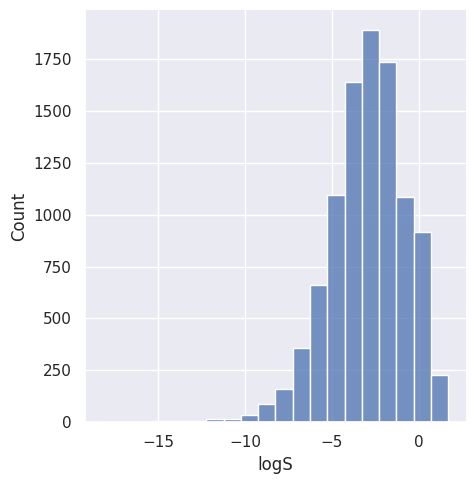

In [9]:
sn.set_theme()
sn.displot(data=data_solubility, x="logS", binwidth=1)

We will then filter compounds that follow as close as normal distribution. We consider values between -7.5 and 1.7 as following a normal distribution.


In [10]:
new_data_solubility = data_solubility[data_solubility.logS.apply(lambda x: x > -7.5 and x < 1.7)]

We will generate a histogram to visualize the distribution of the new data.

(9648, 6)

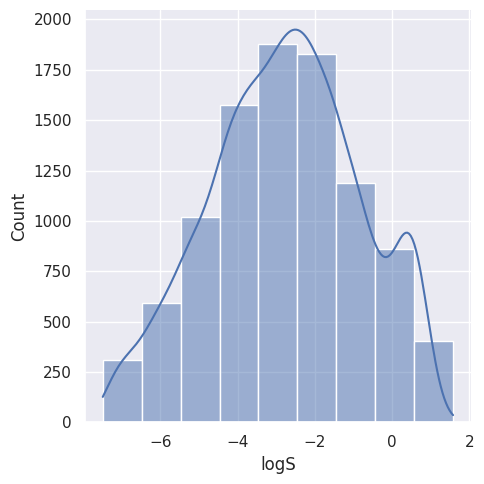

In [11]:
sn.displot(data=new_data_solubility, x='logS', binwidth=1,kde=True)
new_data_solubility.shape

### 2.2.3 Remove Duplicates

Then, we will remove duplicate by generating canonical SMILES.

In [12]:
# Generate a canonical SMILES function
def canonical_SMILES(smiles):
    canon_smls = [Chem.CanonSmiles(smls) for smls in smiles]
    return canon_smls

In [13]:
# Generate canonical Smiles using the function
canon_smiles = canonical_SMILES(new_data_solubility.SMILES)

# Replace SMILES column with canonical SMILES
new_data_solubility["SMILES"] = canon_smiles

# Create a list for duplicate smiles
duplicate_smiles = new_data_solubility[new_data_solubility['SMILES'].duplicated()]['SMILES'].values
len(duplicate_smiles)

6

Upon analysis,we found out that there are six duplicate entries. These duplicates will be filtered out and the dataset will be sorted for improved readability.

In [14]:
new_data_solubility[new_data_solubility['SMILES'].isin(duplicate_smiles)].sort_values(by=['SMILES'])

,Compound ID,InChIKey,SMILES,logS,logP,MW
5683,C1698,WUBBRNOQWQTFEX-UHFFFAOYSA-N,CC(=O)Nc1nnc(S(N)(=O)=O)s1,-2.44,1.00,222.25
5836,C943,BZKPWHYZMXOIDC-UHFFFAOYSA-N,CC(=O)Nc1nnc(S(N)(=O)=O)s1,-2.36,1.00,222.25
7282,C7745,VWPOSFSPZNDTMJ-UCWKZMIHSA-N,CC(C)(C)NCC(O)COc1cccc2c1C[C@H](O)[C@H](O)C2,-1.57,1.03,309.40
8063,C1707,IWVCMVBTMGNXQD-PXOLEDIWSA-N,CC(C)(C)NCC(O)COc1cccc2c1C[C@H](O)[C@H](O)C2,-1.01,1.03,309.40
1345,C199,WKRLQDKEXYKHJB-HFTRVMKXSA-N,C[C@]12CC[C@H]3C(=CCc4cc(O)ccc43)[C@@H]1CCC2=O,-5.28,3.74,268.35
1347,C1673,WKRLQDKEXYKHJB-HFTRVMKXSA-N,C[C@]12CC[C@H]3C(=CCc4cc(O)ccc43)[C@@H]1CCC2=O,-5.28,3.74,268.35
5152,C1696,QZUDBNBUXVUHMW-UHFFFAOYSA-N,Cc1cc(NS(=O)(=O)c2ccc(N)cc2)no1,-2.70,3.10,253.28
5319,C843,JLKIGFTWXXRPMT-UHFFFAOYSA-N,Cc1cc(NS(=O)(=O)c2ccc(N)cc2)no1,-2.62,3.10,253.28
3918,C604,NXFQHRVNIOXGAQ-YCRREMRBSA-N,O=C1CN(/N=C/c2ccc([N+](=O)[O-])o2)C(=O)N1,-3.38,0.86,238.16
4159,C1690,NXFQHRVNIOXGAQ-OQFOIZHKSA-N,O=C1CN(/N=C/c2ccc([N+](=O)[O-])o2)C(=O)N1,-3.24,0.86,238.16


We removed rows containing duplicate SMILES, retaining the first occurrence of each structure.

In [15]:
data_solubility_cleaned = new_data_solubility.drop_duplicates(subset=['SMILES'], keep='first')
data_solubility_cleaned.shape
data_solubility_cleaned.head()

,Compound ID,InChIKey,SMILES,logS,logP,MW
294,C1951,NZFNXWQNBYZDAQ-UHFFFAOYSA-N,CSc1ccc2c(c1)N(CCC1CCCCN1C)c1ccccc1S2.Cl,-7.49,6.69,407.04
295,C1952,CIMQMKORBAJNEC-UHFFFAOYSA-N,CC(=O)OCCN1CCN(CCCN2c3ccccc3Sc3ccc(C(F)(F)F)cc...,-7.49,6.42,552.48
296,C1953,MOPIFNSMNXBREW-UHFFFAOYSA-N,CCCCCCCNc1c2ccccc2nc2ccccc12,-7.48,5.84,292.42
297,C1954,CKHJPWQVLKHBIH-ZDSKVHJSSA-N,C/C(=C(\CCOC(=O)C(C)C)SS/C(CCOC(=O)C(C)C)=C(/C...,-7.47,7.12,702.89
298,C1955,NAPSCFZYZVSQHF-UHFFFAOYSA-N,CCCCCCCCCCCCCCCCCCN(C)C,-7.46,6.81,297.56


### 2.2.4 Filter training data
With the dataset in hand, our next step involves assembling a test set comprising 100 drug-like compounds. These compounds were sourced from https://github.com/PatWalters/solubility.

In [16]:
!wget https://raw.githubusercontent.com/Nohalyan/Projetppchem/main/Data/Data_Drug_Like_Solubility.csv

--2024-05-07 19:13:25--  https://raw.githubusercontent.com/Nohalyan/Projetppchem/main/Data/Data_Drug_Like_Solubility.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5557 (5.4K) [text/plain]
Saving to: ‘Data_Drug_Like_Solubility.csv’

Data_Drug_Like_Solu 100%[===================>]   5.43K  --.-KB/s    in 0s      

2024-05-07 19:13:25 (44.0 MB/s) - ‘Data_Drug_Like_Solubility.csv’ saved [5557/5557]



In [17]:
# Create a Path object for the current directory, in our case /content/
current_directory_dl = Path.cwd()
print("Current Directory:", current_directory.resolve())

file_path_dl = current_directory / "Data_Drug_Like_Solubility.csv"

# Reading the contents of the file and check that the file exists
if file_path.exists():
    with file_path.open("r") as file:
        content = file.read()
#        print(content)
else:
    print("The file does not exist.")

Current Directory: /content


In [18]:
data_dl = pd.read_csv("/content/Data_Drug_Like_Solubility.csv", delimiter=';')
data_dl.shape

(100, 3)

In [19]:
data_dl.head()

,Chemical name,SMILES,LogS exp (mol/L)
0,Acetanilide,O=C(Nc1ccccc1)C,-1.40
1,Adenosine,c1nc(c2c(n1)n(cn2)[C@H]3[C@@H]([C@@H]([C@H](O3...,-1.73
2,Allopurinol,c1c2c([nH]n1)ncnc2O,-2.26
3,Trimethoprim,COc1cc(cc(c1OC)OC)Cc2cnc(nc2N)N,-2.95
4,Acetazolamide,O=S(=O)(c1nnc(s1)NC(=O)C)N,-2.44


In [20]:
# Generate canonical Smiles
canon_smiles = canonical_SMILES(data_dl.SMILES)

# Replace SMILES column wit Canonical SMILES
data_dl["SMILES"] = canon_smiles

# Create a list for duplicate smiles
duplicate_data_dl_smiles = data_dl[data_dl['SMILES'].duplicated()]['SMILES'].values
len(duplicate_data_dl_smiles)

0

Now we need to check that there are no duplicates between the data set and the test data set.

In [21]:
# Molecules used in training and test of the model
data_dl_SMILES = data_dl.SMILES.values

# Filter molecules that are not present in the test set
data_cleaned_final = data_solubility_cleaned[~data_solubility_cleaned['SMILES'].isin(data_dl_SMILES)]
print(f'Compounds present in training set:{len(data_solubility_cleaned) - len(data_cleaned_final)}')
data_cleaned_final.shape

Compounds present in training set:93


(9549, 6)

In [22]:
# Save the dataframe to a CSV file
data_cleaned_final.to_csv('Data_Cleaned_Final.csv', index=False)

In [23]:
data_dl= data_dl[data_dl['LogS exp (mol/L)'].apply(lambda x: x > -7.5 and x < 1.7)]
data_dl

,Chemical name,SMILES,LogS exp (mol/L)
0,Acetanilide,CC(=O)Nc1ccccc1,-1.40
1,Adenosine,Nc1ncnc2c1ncn2[C@@H]1O[C@H](CO)[C@@H](O)[C@H]1O,-1.73
2,Allopurinol,Oc1ncnc2[nH]ncc12,-2.26
3,Trimethoprim,COc1cc(Cc2cnc(N)nc2N)cc(OC)c1OC,-2.95
4,Acetazolamide,CC(=O)Nc1nnc(S(N)(=O)=O)s1,-2.44
...,...,...,...
95,Sulfanilamide,Nc1ccc(S(N)(=O)=O)cc1,-1.36
96,Gliclazide,Cc1ccc(S(=O)(=O)NC(=O)NN2CC3CCCC3C2)cc1,-4.29
97,Trihexyphenidyl,OC(CCN1CCCCC1)(c1ccccc1)C1CCCCC1,-5.20
98,Triphenylene,c1ccc2c(c1)c1ccccc1c1ccccc21,-6.73


# 3. Calculation of RDkit Molecular Descriptors

Calculation of RDkit Molecular Descriptors, which are molecular features for the data set and the test data set

In [ ]:
def RDkit_descriptors(smiles):
    mols = [Chem.MolFromSmiles(i) for i in smiles]
    calc = MoleculeDescriptors.MolecularDescriptorCalculator([x[0]
                                    for x in Descriptors._descList])
    desc_names = calc.GetDescriptorNames()

    Mol_descriptors =[]
    for mol in tqdm(mols):
        # add hydrogens to molecules
        mol=Chem.AddHs(mol)
        # Calculate all 200 descriptors for each molecule
        descriptors = calc.CalcDescriptors(mol)
        Mol_descriptors.append(descriptors)
    return Mol_descriptors,desc_names

# Function call
Mol_descriptors,desc_names = RDkit_descriptors(data_cleaned_final['SMILES'])

In [ ]:
df_descriptors = pd.DataFrame(Mol_descriptors, columns=desc_names)
df_descriptors.head()

In [ ]:
# Calculate molecular descriptors for the test data or 98 compounds
Mol_descriptors_test , desc_names_test = RDkit_descriptors(data_dl["SMILES"])
data_dl_descriptors = pd.DataFrame(Mol_descriptors_test,columns=desc_names_test)

In [ ]:
# Save the dataf to .csv files
df_descriptors.to_csv('Data_Solubility_descriptor.csv', index=False)
data_dl_descriptors.to_csv('Data_Solubility_Drug_Like_descriptor.csv', index=False)

# 4. Training and Validation set

In this part, we will separate the data from the data set into 2 sets: the training set to train the model and the validation set to provide an evaluation of the model on the training dataset to adjust the hyperparameters.

If you have run sections 2. and 3., you can skip to section 4.2, otherwise you must run section 4.1.

##4.1 Acquisition of Sorted, Cleaned Data Sets and RDkit Molecular Descriptors

In [24]:
#Download cleaned and sorted data (Data_Cleaned_Final.csv) with RDkit molecular descriptors (Data_Solubility_descriptor.csv) for training and validation set
!wget https://raw.githubusercontent.com/Nohalyan/Projetppchem/main/Data/Data_Cleaned_Final.csv
!wget https://raw.githubusercontent.com/Nohalyan/Projetppchem/main/Data/Data_Solubility_descriptor.csv

#Download cleaned and sorted data (Data_Drug_Like_Solubility.csv) with RDkit molecular descriptors (Data_Solubility_Drug_Like_descriptor.csv) for test set
!wget https://raw.githubusercontent.com/Nohalyan/Projetppchem/main/Data/Data_Drug_Like_Solubility.csv
!wget https://raw.githubusercontent.com/Nohalyan/Projetppchem/main/Data/Data_Solubility_Drug_Like_descriptor.csv

--2024-05-07 19:13:26--  https://raw.githubusercontent.com/Nohalyan/Projetppchem/main/Data/Data_Cleaned_Final.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 929243 (907K) [text/plain]
Saving to: ‘Data_Cleaned_Final.csv.1’

Data_Cleaned_Final. 100%[===================>] 907.46K  --.-KB/s    in 0.05s   

2024-05-07 19:13:27 (17.1 MB/s) - ‘Data_Cleaned_Final.csv.1’ saved [929243/929243]

--2024-05-07 19:13:27--  https://raw.githubusercontent.com/Nohalyan/Projetppchem/main/Data/Data_Solubility_descriptor.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting 

In [25]:
#To verify that the file was correctly downloaded
# Create a Path object for the current directory, in our case /content/
current_directory = Path.cwd()
print("Current Directory:", current_directory.resolve())

file_path = current_directory / "Data_Solubility_Drug_Like_descriptor.csv" #Copy and paste the file name

# Reading the contents of the file and check that the file exists
if file_path.exists():
    with file_path.open("r") as file:
        content = file.read()
        print(content)
else:
    print("The file does not exist.")


Current Directory: /content
MaxAbsEStateIndex,MaxEStateIndex,MinAbsEStateIndex,MinEStateIndex,qed,SPS,MolWt,HeavyAtomMolWt,ExactMolWt,NumValenceElectrons,NumRadicalElectrons,MaxPartialCharge,MinPartialCharge,MaxAbsPartialCharge,MinAbsPartialCharge,FpDensityMorgan1,FpDensityMorgan2,FpDensityMorgan3,BCUT2D_MWHI,BCUT2D_MWLOW,BCUT2D_CHGHI,BCUT2D_CHGLO,BCUT2D_LOGPHI,BCUT2D_LOGPLOW,BCUT2D_MRHI,BCUT2D_MRLOW,AvgIpc,BalabanJ,BertzCT,Chi0,Chi0n,Chi0v,Chi1,Chi1n,Chi1v,Chi2n,Chi2v,Chi3n,Chi3v,Chi4n,Chi4v,HallKierAlpha,Ipc,Kappa1,Kappa2,Kappa3,LabuteASA,PEOE_VSA1,PEOE_VSA10,PEOE_VSA11,PEOE_VSA12,PEOE_VSA13,PEOE_VSA14,PEOE_VSA2,PEOE_VSA3,PEOE_VSA4,PEOE_VSA5,PEOE_VSA6,PEOE_VSA7,PEOE_VSA8,PEOE_VSA9,SMR_VSA1,SMR_VSA10,SMR_VSA2,SMR_VSA3,SMR_VSA4,SMR_VSA5,SMR_VSA6,SMR_VSA7,SMR_VSA8,SMR_VSA9,SlogP_VSA1,SlogP_VSA10,SlogP_VSA11,SlogP_VSA12,SlogP_VSA2,SlogP_VSA3,SlogP_VSA4,SlogP_VSA5,SlogP_VSA6,SlogP_VSA7,SlogP_VSA8,SlogP_VSA9,TPSA,EState_VSA1,EState_VSA10,EState_VSA11,EState_VSA2,EState_VSA3,EState_VSA4,ESt

In [26]:
#Variable definitions, if not defined in sections 2. and 3.
data_dl = pd.read_csv("/content/Data_Drug_Like_Solubility.csv", delimiter=';')
data_dl= data_dl[data_dl['LogS exp (mol/L)'].apply(lambda x: x > -7.5 and x < 1.7)]
df_descriptors = pd.read_csv("/content/Data_Solubility_descriptor.csv", delimiter=';')
data_cleaned_final = pd.read_csv("/content/Data_Cleaned_Final.csv", delimiter=',')
data_dl_descriptors = pd.read_csv("/content/Data_Solubility_Drug_Like_descriptor.csv", delimiter=',')

## 4.2  Split the chemicals for training and validation set

In [27]:
#Variable definitions for training and set validation
x_train, x_valid, y_train, y_valid = train_test_split(df_descriptors, data_cleaned_final.logS, test_size=0.1,random_state=42)

#Standardization of the features
scaler = StandardScaler()
scaler.fit(x_train)
x_train_scaled = scaler.transform(x_train)
x_valid_scaled = scaler.transform(x_valid)

#5. Select Machine Learning Models

Let's identify the optimal machine learning models for our water solubility predisction. To accomplish this, we will utilize the "lazypredict" library, specifically leveraging the "LazyRegressor" function to evaluate a selection of 42 machine learning models.

In [ ]:
lregs = LazyRegressor(verbose=0,ignore_warnings=True, custom_metric=None,random_state=42)
models, prediction_tests = lregs.fit(x_train_scaled, x_valid_scaled, y_train, y_valid)

In [ ]:
#The top five models
prediction_tests[:5]

# 6. Fine-tuning

We decided to use the top 3 models, starting from the fatest to the slowest.

## 6.1 LGBMRegressor

We decided to take the LGBMRegressor model because the results generated by this model are comparable to the ExtraTreesRegressor model, but takes a lot less time than the ExtraTreesRegressor model.Let's performs a grid search using GridSearchCV from scikit-learn to find the best hyperparameters for a LightGBM regressor:

In [ ]:
params = {'max_depth' : list(range(20, 30, 1)),
          'n_estimators' : list(range(1278, 1280, 1)) ,
          'learning_rate': list(np.arange(0.04, 0.05, 0.01))}

grid_search = GridSearchCV(LGBMRegressor(random_state = 42),
                            param_grid=params, cv=5, verbose=1)

grid_search.fit(x_train, y_train)

print("Optimized parameters for a LightGBM regressor can be: ", grid_search.best_params_)

We obtained:
* learning_rate: 0.01
* max_depth: 26
* n_estmitors: 901

Let's optimize again with new ranges for max_depth, n_estmitors and learning_rate to obtain even better parameters:


In [ ]:
#params_bst = {"max_depth" : list(range(20, 36, 4)),
#         "n_estimators" : list(range(850, 1200, 50)),
#         "learning_rate" : list(np.arange(0.01, 0.05, 0.01))}
#
#grid_search_bst = GridSearchCV(LGBMRegressor(random_state = 42),
#                                  param_grid=params_bst, cv=3, verbose=1)
#
#grid_search_bst.fit(x_train, y_train)
#print("The best parameters are: ", grid_search_bst.best_params_)

We obtained:
* learning_rate: 0.04
* max_depth: 24
* n_estmitors: 1151

These are the parameters we will use for our standard LGBMRegressor model.

We also wanted to see if by making new runs and trying to optimize these three hyperparameters even further, we could get an even better model. We therefore made a total of 6 runs (compared with the 2 runs for standard models) for this model and obtained these parameters:
* learning_rate: 0.04
* max_depth: 21
* n_estmitors: 1279

These are the parameters we will use for our studious LGBMRegressor model.

##6.2 XGB Regressor
In order to compare our results obtained for the first model, we have chosen XGB Regressor as the second model for the reasons presented above.

The following code performs hyperparameter optimisation for the XGBoost regression model using grid search with cross-validation.

1. We splited the training data associated with their target variable (i.e. logS in our case) into training and validation sets using train_test_split. The size of the validation set is set to 20% of the total data, and a random seed of 42 is used for reproducibility

2. The training and validation features are scaled using StandardScaler, which standardises the features by removing the mean and obtaining a unit variance

3. A grid of hyperparameters to explore is defined, including the max_depths, n_estimators and learning_rates lists, containing different values for each hyperparameter. By initialising the best_score and best_params variables, the best performances obtained during the search are tracked

4. All the combinations of hyperparameters defined in the grid are tested. For each combination, it creates an XGBoost regression model with the current hyperparameters, fits it to the training data and then evaluates its performance on the validation set using the coefficient of determination score (R^2)

5. If the current combination of hyperparameters produces a higher score than the previous score, the best_score and best_params variables change with the new values

6. The optimised values are then displayed at the end of the various tests

In [ ]:
import numpy as np
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Assuming x_train and y_train are already defined

# Split data into training and validation sets
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=42)

# Data preprocessing
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_val_scaled = scaler.transform(x_val)

# Define the parameter grid
max_depths = list(range(2, 32, 8))
n_estimators = list(range(1, 201, 20))
learning_rates = list(np.arange(0.01, 1.02, 0.25))

best_score = float('-inf')
best_params = {}

# Iterate over parameter combinations
for max_depth in max_depths:
    for n_estimator in n_estimators:
        for learning_rate in learning_rates:
            # Create XGBoost regressor with current parameters
            xgb_regressor = XGBRegressor(max_depth=max_depth,
                                         n_estimators=n_estimator,
                                         learning_rate=learning_rate,
                                         random_state=42)

            # Fit the model
            xgb_regressor.fit(x_train_scaled, y_train)

            # Evaluate the model
            score = xgb_regressor.score(x_val_scaled, y_val)  # Using the validation set for evaluation

            # Check if current parameters yield better score
            if score > best_score:
                best_score = score
                best_params = {'max_depth': max_depth, 'n_estimators': n_estimator, 'learning_rate': learning_rate}

# Print the best parameters found
print("Optimized parameters for an XGBoost regressor can be:", best_params)

We obtained for this first run:
- max_depth: 2
- n_estimators: 181
- learning_rate: 0.26

In [ ]:
import numpy as np
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Assuming x_train and y_train are already defined

# Split data into training and validation sets
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=42)

# Data preprocessing
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_val_scaled = scaler.transform(x_val)

# Define the parameter grid
max_depths = list(range(2, 6, 1))
n_estimators = list(range(100, 700, 50))
learning_rates = list(np.arange(0.05, 0.30, 0.05))

best_score = float('-inf')
best_params = {}

# Iterate over parameter combinations
for max_depth in max_depths:
    for n_estimator in n_estimators:
        for learning_rate in learning_rates:
            # Create XGBoost regressor with current parameters
            xgb_regressor = XGBRegressor(max_depth=max_depth,
                                         n_estimators=n_estimator,
                                         learning_rate=learning_rate,
                                         random_state=42)

            # Fit the model
            xgb_regressor.fit(x_train_scaled, y_train)

            # Evaluate the model
            score = xgb_regressor.score(x_val_scaled, y_val)  # Using the validation set for evaluation

            # Check if current parameters yield better score
            if score > best_score:
                best_score = score
                best_params = {'max_depth': max_depth, 'n_estimators': n_estimator, 'learning_rate': learning_rate}

# Print the best parameters found
print("Optimized parameters for an XGBoost regressor can be:", best_params)


We obtained for this second run:

- max_depth: 5
- n_estimators: 500
- learning_rate: 0.1

These are the parameters we will use for our standard LGBMRegressor model.

##6.3 HistGradientBoostingClassifier

In [ ]:
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.model_selection import GridSearchCV
import numpy as np

# Define the parameter grid
params = {
    'max_depth': list(range(20, 30, 1)),
    'learning_rate': list(np.arange(0.04, 0.05, 0.01))
}

# Create a GridSearchCV instance for HistGradientBoostingRegressor
grid_search = GridSearchCV(
    HistGradientBoostingRegressor(random_state=42),
    param_grid=params,
    cv=5,
    verbose=1
)

# Fit the GridSearchCV instance
grid_search.fit(x_train, y_train)

# Print the optimized parameters
print("Optimized parameters for a HistGradientBoostingRegressor:")
print(grid_search.best_params_)

We obtained for this first run:
- learning_rate: 0.05

- max_depth: 20

In [ ]:
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.model_selection import GridSearchCV
import numpy as np

# Define the parameter grid
params = {
    'max_depth': list(range(1, 21, 2)),
    'learning_rate': list(np.arange(0.04, 0.10, 0.02))
}

# Create a GridSearchCV instance for HistGradientBoostingRegressor
grid_search = GridSearchCV(
    HistGradientBoostingRegressor(random_state=42),
    param_grid=params,
    cv=5,
    verbose=1
)

# Fit the GridSearchCV instance
grid_search.fit(x_train, y_train)

# Print the optimized parameters
print("Optimized parameters for a HistGradientBoostingRegressor:")
print(grid_search.best_params_)

We obtained for the second run:
- learning_rate: 0.07999999999999999

- max_depth: 13

In [ ]:
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.model_selection import GridSearchCV
import numpy as np

# Define the parameter grid
params = {
    'max_depth': list(range(11, 15, 1)),
    'learning_rate': list(np.arange(0.06, 0.10, 0.005))
}

# Create a GridSearchCV instance for HistGradientBoostingRegressor
grid_search = GridSearchCV(
    HistGradientBoostingRegressor(random_state=42),
    param_grid=params,
    cv=5,
    verbose=1
)

# Fit the GridSearchCV instance
grid_search.fit(x_train, y_train)

# Print the optimized parameters
print("Optimized parameters for a HistGradientBoostingRegressor:")
print(grid_search.best_params_)

Finally, we obtained for the second run:

- learning_rate: 0.095

- max_depth: 14

# 7. Models for training and test data

Let's test our models on the training and test set with the best parameters found with the fine tunning:

## 7.1.1 LGBMRegressor (trained 2 times)

In [7]:
model = LGBMRegressor(n_estimators = 1151,
                      max_depth = 24,
                      learning_rate = 0.04,
                      random_state= 42)

model.fit(x_train_scaled,y_train)
y_preds = model.predict(x_valid_scaled)

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.014410 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 20903
[LightGBM] [Info] Number of data points in the train set: 8594, number of used features: 195
[LightGBM] [Info] Start training from score -2.762630
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


In [8]:
def plot_data(actual, predicted, title):

    rmse = np.sqrt(mean_squared_error(actual, predicted))

    R2 =r2_score(actual, predicted)
    plt.figure(figsize=(8,6))


    # Plot the figure
    sn.regplot(x=predicted, y=actual, line_kws={"lw": 2, "ls": "--", "color": "red", "alpha": 0.7})
    plt.title(title, color="red")
    plt.xlabel("Predicted logS(mol/L)", color="blue")
    plt.xlim(-8, 1)
    plt.ylabel("Experimental logS(mol/L)", color="blue")
    plt.grid(alpha=0.3)
    R2_patch = mpatches.Patch(label="R2={:04.2f}".format(R2))
    rmse_patch = mpatches.Patch(label="RMSE={:04.2f}".format(rmse))
    plt.legend(handles=[R2_patch, rmse_patch])

Let's plot the predicted logS of the validation set and see if our model works.

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

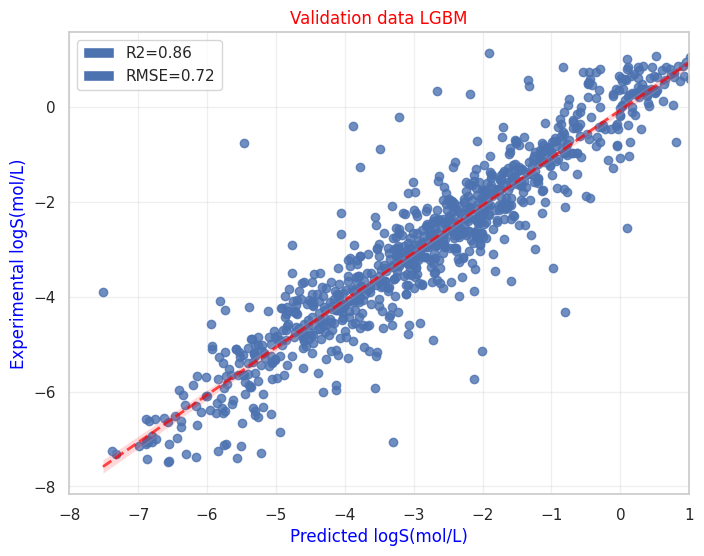

In [61]:
# Plot data
plot_data(y_valid, y_preds, "Validation data LGBM")

# Save the plot as PNG
plt.savefig('/content/data_LGBM.png')

# Download the plot
files.download('/content/data_LGBM.png')

# Save data to CSV
data_to_save = pd.DataFrame({'True Values': y_valid, 'Predicted Values': y_preds})
data_to_save.to_csv('/content/data_LGBM.csv', index=False)

# Download the CSV file
files.download('/content/data_LGBM.csv')

In [58]:
# Standard scaler - transform
x_scaled_test = scaler.transform(data_dl_descriptors)

# Predict solubility of the test data
y_test_preds = model.predict(x_scaled_test)

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

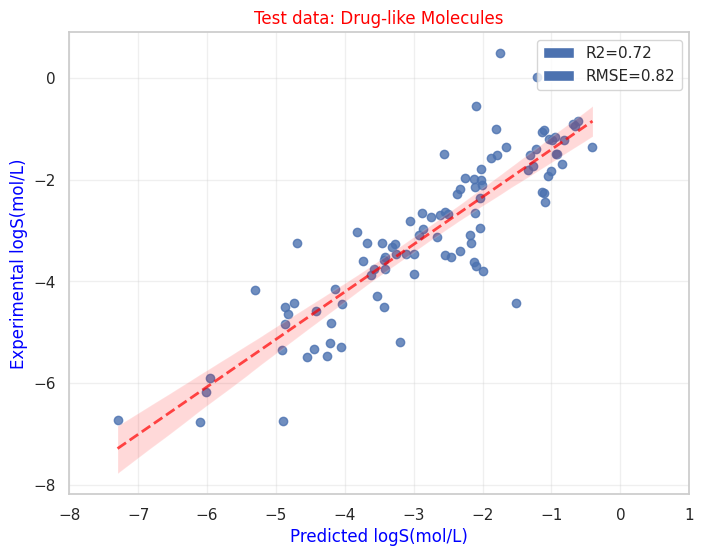

In [60]:
sn.set_theme(style="whitegrid")
plot_data(data_dl['LogS exp (mol/L)'][:98], y_test_preds,
           "Test data: Drug-like Molecules")

# Save the plot as PNG
plt.savefig('/content/test_data_LGBM.png')

# Download the plot
files.download('/content/test_data_LGBM.png')

# Save data to CSV
data_to_save = pd.DataFrame({'True Values': data_dl["LogS exp (mol/L)"], 'Predicted Values': y_test_preds})
data_to_save.to_csv('/content/test_data_LGBM.csv', index=False)
files.download('/content/test_data_LGBM.csv')


## 7.1.2 LGBMRegressor (trained 6 times)






In [64]:
model_LGMB6 = LGBMRegressor(n_estimators = 1279,
                      max_depth = 21,
                      learning_rate = 0.04,
                      random_state= 42)

model_LGMB6.fit(x_train_scaled,y_train)
y_preds_LGMB6 = model_LGMB6.predict(x_valid_scaled)

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010085 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 20903
[LightGBM] [Info] Number of data points in the train set: 8594, number of used features: 195
[LightGBM] [Info] Start training from score -2.762630
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


In [ ]:
# A plotting function
def plot_data(actual, predicted, title):

# model performance using RMSE
    rmse = np.sqrt(mean_squared_error(actual, predicted))

# R^2 (coefficient of determination) :
    R2 =r2_score(actual, predicted)
    plt.figure(figsize=(8,6))

# Plot the figure
    sn.regplot(x=predicted , y=actual,line_kws={"lw":2,
                                                "ls":"--",
                                                "color":"red",
                                                "alpha":0.7})
    plt.title(title, color="red")
    plt.xlabel("Predicted logS(mol/L)",
               color="blue")
    plt.xlim(-8,1)
    plt.ylabel("Experimental logS(mol/L)",
               color ="blue")

    plt.grid(alpha=0.3)
    R2_patch = mpatches.Patch(label="R2={:04.2f}".format(R2))
    rmse_patch = mpatches.Patch(label="RMSE={:04.2f}".format(rmse))
    plt.legend(handles=[R2_patch, rmse_patch])

Let's plot the predicted logS of the validation set and see if our model works.




<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

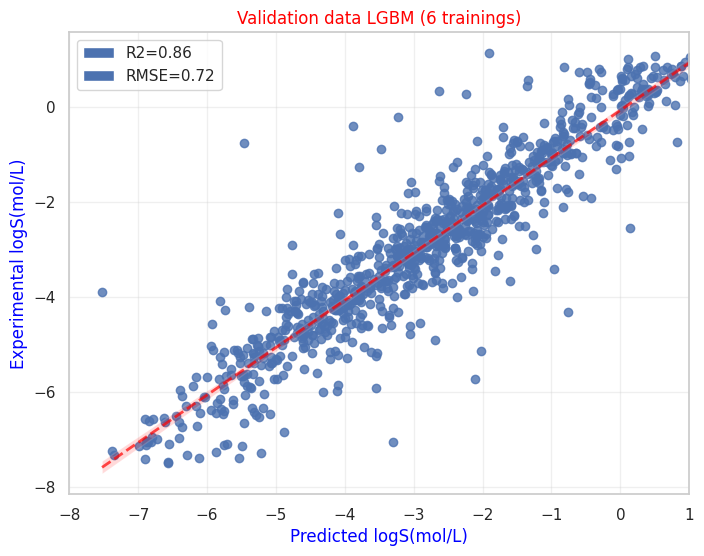

In [65]:
from google.colab import files

sn.set_theme(style="whitegrid")
plot_data(y_valid,y_preds_LGMB6,"Validation data LGBM (6 trainings)")

# Save the plot as PNG
plt.savefig('/content/data_LGBM_6trainings.png')

# Download the plot
files.download('/content/data_LGBM_6trainings.png')

# Save data to CSV
data_to_save = pd.DataFrame({'True Values': data_dl["LogS exp (mol/L)"], 'Predicted Values': y_test_preds})
data_to_save.to_csv('/content/data_LGBM_6trainings.csv', index=False)
files.download('/content/data_LGBM_6trainings.csv')

In [70]:
def plot_data_LGBM2V6(actual, predicted, title, color=None):
    plt.figure(figsize=(8, 6))
    plt.scatter(predicted, actual, alpha=0.5, color=color)  # Using color parameter here
    plt.title(title)
    plt.xlabel("Predicted Values")
    plt.ylabel("Actual Values")
    plt.grid(alpha=0.3)
    plt.show()


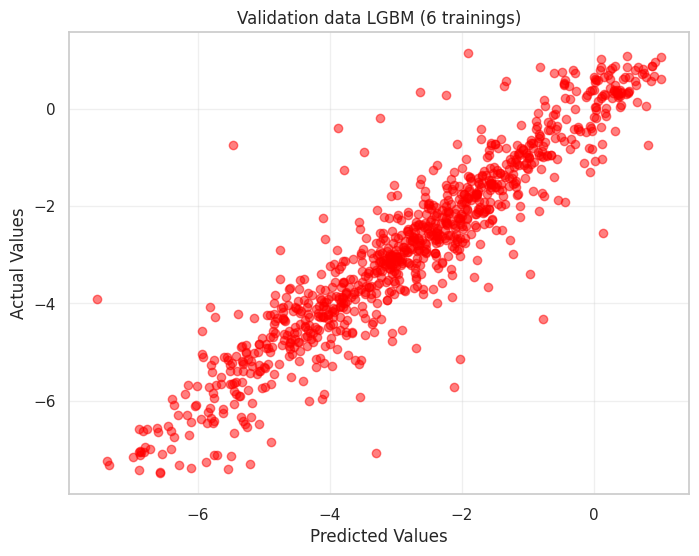

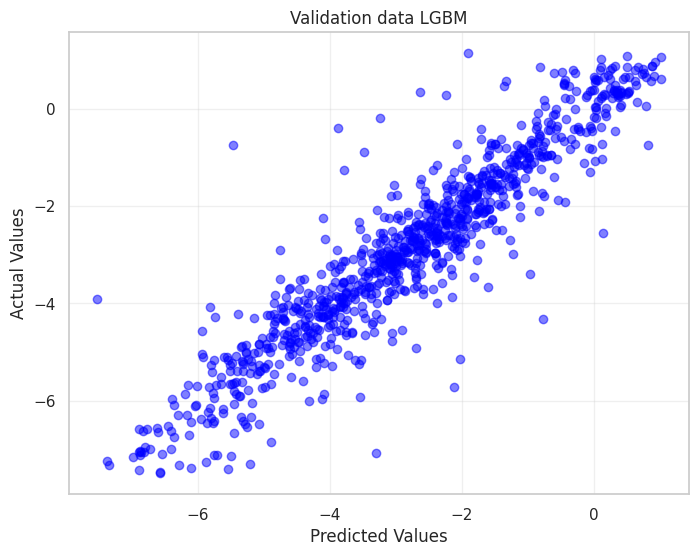

In [71]:
import seaborn as sn

# Set seaborn theme
sn.set_theme(style="whitegrid")

# Assuming plot_data function is defined elsewhere

# Plot data with y_preds_LGMB6 in red
plot_data_LGBM2V6(y_valid, y_preds_LGMB6, title="Validation data LGBM (6 trainings)", color="red")

# Plot data with y_preds in blue
plot_data_LGBM2V6(y_valid, y_preds, title="Validation data LGBM", color="blue")


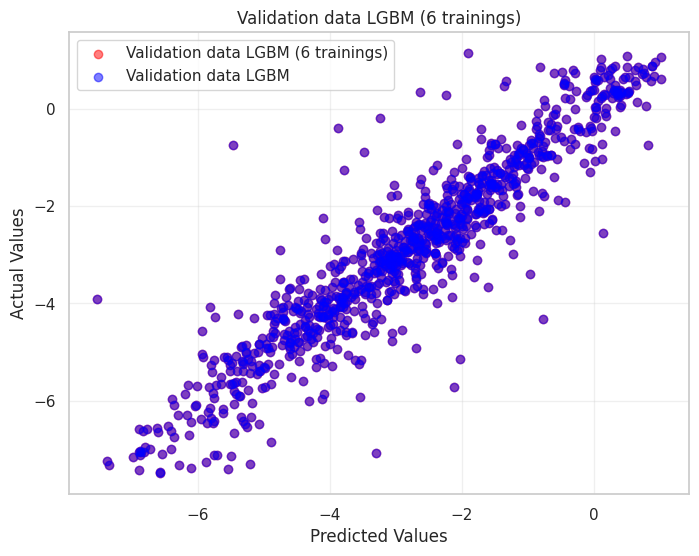

In [72]:
import seaborn as sn
import matplotlib.pyplot as plt

# Set seaborn theme
sn.set_theme(style="whitegrid")

# Define the plot_data_LGBM2V6 function
def plot_data_LGBM2V6(actual1, predicted1, title1, actual2, predicted2, title2):
    plt.figure(figsize=(8, 6))

    # Plot the first set of data
    plt.scatter(predicted1, actual1, alpha=0.5, color="red", label=title1)

    # Plot the second set of data
    plt.scatter(predicted2, actual2, alpha=0.5, color="blue", label=title2)

    # Add titles and labels
    plt.title("Validation data LGBM (6 trainings)")
    plt.xlabel("Predicted Values")
    plt.ylabel("Actual Values")
    plt.grid(alpha=0.3)

    # Add legend
    plt.legend()

    plt.show()

# Call the function to plot both sets of data on the same graph
plot_data_LGBM2V6(y_valid, y_preds_LGMB6, "Validation data LGBM (6 trainings)", y_valid, y_preds, "Validation data LGBM")


In [ ]:
# Standard scaler - transform
x_scaled_test = scaler.transform(data_dl_descriptors)

# Predict solubility of the test data
y_test_preds = model.predict(x_scaled_test)

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

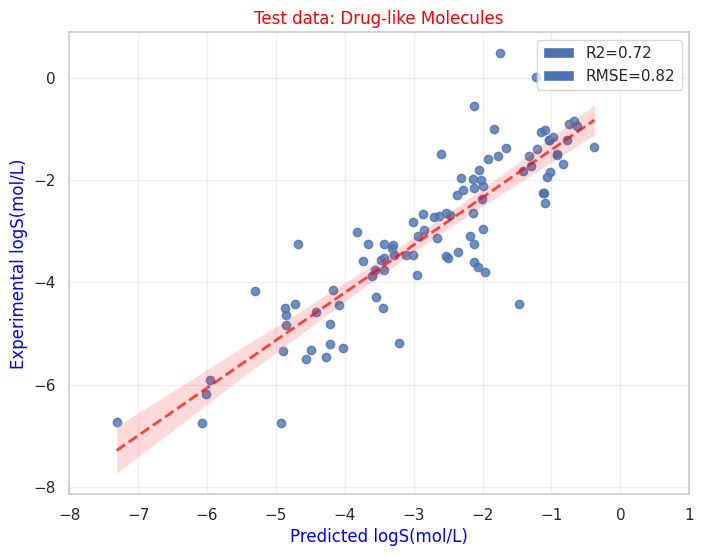

In [ ]:
sn.set_theme(style="whitegrid")
plot_data(data_dl["LogS exp (mol/L)"], y_test_preds,
           "Test data: Drug-like Molecules")

# Save the plot as PNG
plt.savefig('/content/test_data_LGBM_6trainings.png')

# Download the plot
files.download('/content/test_data_LGBM_6trainings.png')

# Save data to CSV
data_to_save = pd.DataFrame({'True Values': data_dl["LogS exp (mol/L)"], 'Predicted Values': y_test_preds})
data_to_save.to_csv('/content/test_data_LGBM_6trainings.csv', index=False)
files.download('/content/test_data_LGBM_6trainings.csv')

## 7.2 XGB Regressor


In [19]:
from xgboost import XGBRegressor

model_XGB = XGBRegressor(n_estimators = 500,
                         max_depth = 5,
                         learning_rate = 0.1,
                         random_state = 42)
model_XGB.fit(x_train_scaled,y_train)
y_preds_XGB = model_XGB.predict(x_valid_scaled)

In [74]:
# A plotting function
def plot_data_XGB(actual, predicted, title):

# model performance using RMSE
    rmse_XGB = np.sqrt(mean_squared_error(actual, predicted))

# R^2 (coefficient of determination) :
    R2_XGB =r2_score(actual, predicted)
    plt.figure(figsize=(8,6))

# Plot the figure
    sn.regplot(x=predicted , y=actual,line_kws={"lw":2,
                                                "ls":"--",
                                                "color":"red",
                                                "alpha":0.7})
    plt.title(title, color="red")
    plt.xlabel("Predicted logS(mol/L)",
               color="blue")
    plt.xlim(-8,1)
    plt.ylabel("Experimental logS(mol/L)",
               color ="blue")


    plt.grid(alpha=0.3)
    R2_patch_XGB = mpatches.Patch(label="R2_XGB={:04.2f}".format(R2_XGB))
    rmse_patch_XGB = mpatches.Patch(label="RMSE_XGB={:04.2f}".format(rmse_XGB))
    plt.legend(handles=[R2_patch_XGB, rmse_patch_XGB])


Let's plot the predicted logS of the validation set and see if our model works.

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

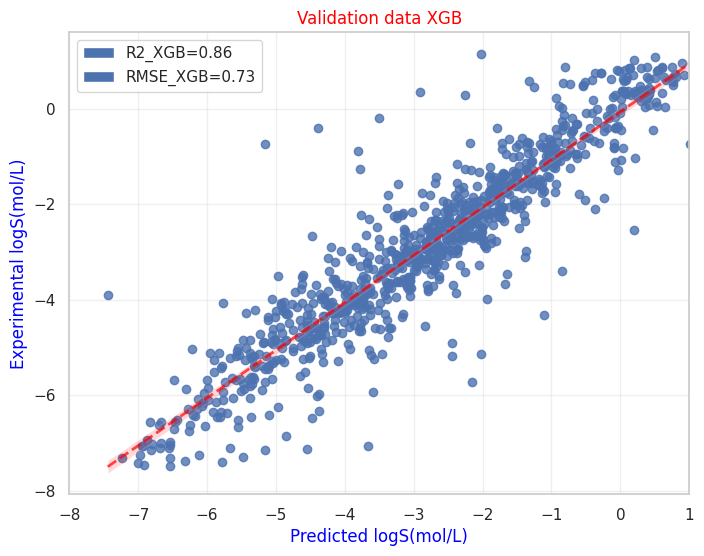

In [77]:
plot_data_XGB(y_valid,y_preds_XGB,"Validation data XGB")

# Save the plot as PNG
plt.savefig('/content/data_XGB.png')

# Download the plot
files.download('/content/data_XGB.png')

# Save data to CSV
data_to_save_XGB = pd.DataFrame({'True Values': y_valid, 'Predicted Values': y_preds_XGB})
data_to_save_XGB.to_csv('/content/data_XGB.csv', index=False)
files.download('/content/data_XGB.csv')

In [78]:
# Standard scaler - transform
x_scaled_test = scaler.transform(data_dl_descriptors)

# Predict solubility of the test data
y_test_preds_XGB = model_XGB.predict(x_scaled_test)

Let's plot the predicted logS of the validation set and see if our model works.

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

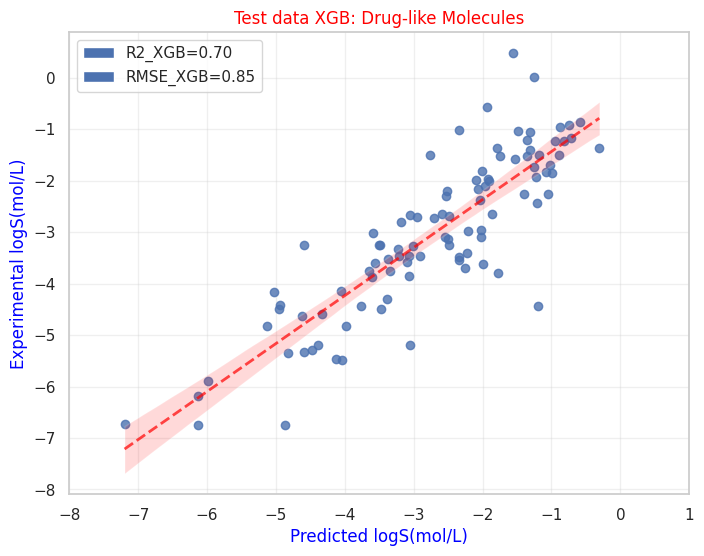

In [79]:
# Plotting testing set for XGB
sn.set_theme(style="whitegrid")
plot_data_XGB(data_dl["LogS exp (mol/L)"], y_test_preds_XGB,
           "Test data XGB: Drug-like Molecules")

# Save the plot as PNG
plt.savefig('/content/test_data_XGB.png')

# Download the plot
files.download('/content/test_data_XGB.png')

# Save data to CSV
data_to_save_test_XGB = pd.DataFrame({'True Values': data_dl["LogS exp (mol/L)"], 'Predicted Values': y_test_preds_XGB})
data_to_save_test_XGB.to_csv('/content/test_data_XGB.csv', index=False)
files.download('/content/test_data_XGB.csv')

##7.3 HistGradientBoostingClassifier

In [80]:
from sklearn.ensemble import HistGradientBoostingRegressor

model_HGB = HistGradientBoostingRegressor(max_depth = 14,
                         learning_rate = 0.095,
                         random_state = 42)
model_HGB.fit(x_train_scaled,y_train)
y_preds_HGB = model_HGB.predict(x_valid_scaled)

In [82]:
def plot_data_HGB(actual, predicted, title):

    rmse_HGB = np.sqrt(mean_squared_error(actual, predicted))


    R2_HGB =r2_score(actual, predicted)
    plt.figure(figsize=(8,6))

# Plot the figure
    sn.regplot(x=predicted , y=actual,line_kws={"lw":2,
                                                "ls":"--",
                                                "color":"red",
                                                "alpha":0.7})
    plt.title(title, color="red")
    plt.xlabel("Predicted logS(mol/L)",
               color="blue")
    plt.xlim(-8,1)
    plt.ylabel("Experimental logS(mol/L)",
               color ="blue")

    plt.grid(alpha=0.3)
    R2_patch_HGB = mpatches.Patch(label="R2_HGB={:04.2f}".format(R2_HGB))
    rmse_patch_HGB = mpatches.Patch(label="RMSE_HGB={:04.2f}".format(rmse_HGB))
    plt.legend(handles=[R2_patch_HGB, rmse_patch_HGB])

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

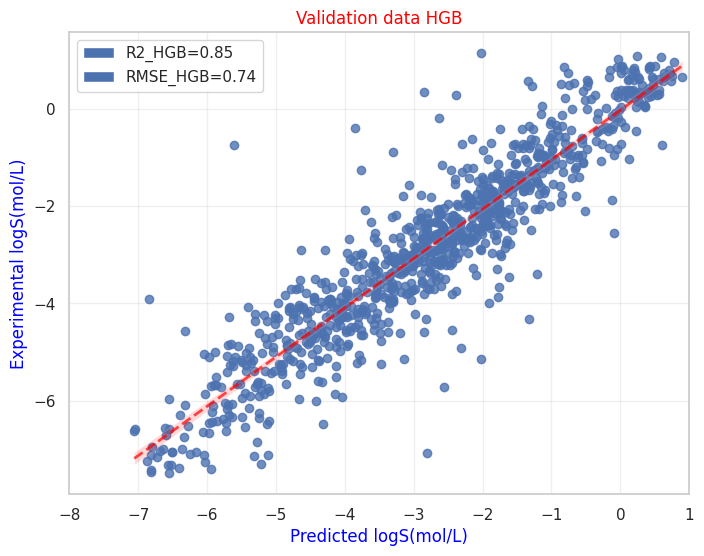

In [84]:
sn.set_theme(style="whitegrid")
plot_data_HGB(y_valid,y_preds_HGB,"Validation data HGB")

# Save the plot as PNG
plt.savefig('/content/data_HGB.png')

# Download the plot
files.download('/content/data_HGB.png')

# Save data to CSV
data_to_save_HGB = pd.DataFrame({'True Values': y_valid, 'Predicted Values': y_preds_HGB})
data_to_save_HGB.to_csv('/content/data_HGB.csv', index=False)
files.download('/content/data_HGB.csv')

In [85]:
# Standard scaler - transform
x_scaled_test = scaler.transform(data_dl_descriptors)

# Predict solubility of the test data
y_test_preds_HGB = model_HGB.predict(x_scaled_test)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

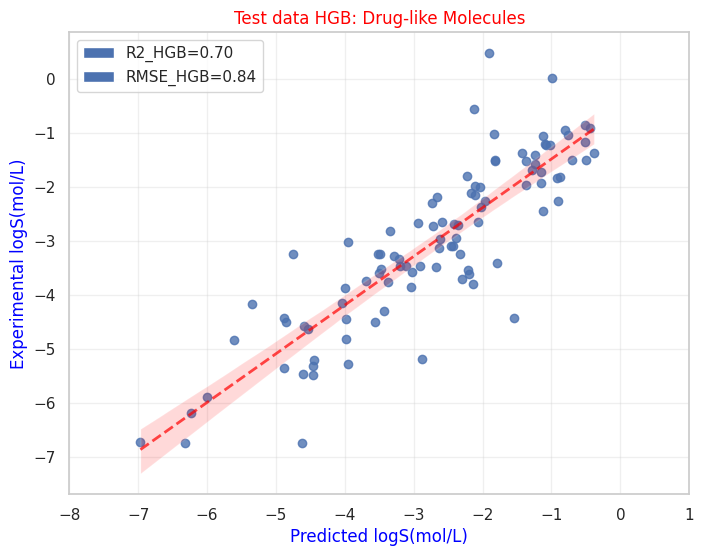

In [86]:
from google.colab import files

# Plotting testing set for HGB
sn.set_theme(style="whitegrid")
plot_data_HGB(data_dl["LogS exp (mol/L)"], y_test_preds_HGB,
           "Test data HGB: Drug-like Molecules")

# Save the plot as PNG
plt.savefig('/content/test_data_HGB.png')

# Download the plot
files.download('/content/test_data_HGB.png')

# Save data to CSV
data_to_save_test_HGB = pd.DataFrame({'True Values': data_dl["LogS exp (mol/L)"], 'Predicted Values': y_test_preds_HGB})
data_to_save_test_HGB.to_csv('/content/test_data_HGB.csv', index=False)
files.download('/content/test_data_HGB.csv')

##7.4 Analysis between the differents Regressors

In [28]:
!wget https://raw.githubusercontent.com/Nohalyan/Projetppchem/Enzo/DatasFromRegressors/data_HGB.csv


--2024-05-07 19:13:33--  https://raw.githubusercontent.com/Nohalyan/Projetppchem/Enzo/DatasFromRegressors/data_HGB.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 30291 (30K) [text/plain]
Saving to: ‘data_HGB.csv’

data_HGB.csv        100%[===================>]  29.58K  --.-KB/s    in 0.002s  

2024-05-07 19:13:33 (12.0 MB/s) - ‘data_HGB.csv’ saved [30291/30291]



In [29]:
current_directory_data_HGB = Path.cwd()
print("Current Directory:", current_directory.resolve())
file_path_data_HGB = current_directory / "data_HGB.csv"
if file_path_data_HGB.exists():
    with file_path_data_HGB.open("r") as file:
        content = file.read()
else:
    print("The file does not exist.")
data_HGB = pd.read_csv("/content/data_HGB.csv", delimiter=',')
data_HGB.shape

Current Directory: /content


(955, 2)

In [30]:
!wget https://raw.githubusercontent.com/Nohalyan/Projetppchem/Enzo/DatasFromRegressors/data_LGBM.csv
!wget https://raw.githubusercontent.com/Nohalyan/Projetppchem/Enzo/DatasFromRegressors/data_LGBM_6trainings.csv
!wget https://raw.githubusercontent.com/Nohalyan/Projetppchem/Enzo/DatasFromRegressors/data_XGB.csv
!wget https://raw.githubusercontent.com/Nohalyan/Projetppchem/Enzo/DatasFromRegressors/test_data_HGB.csv
!wget https://raw.githubusercontent.com/Nohalyan/Projetppchem/Enzo/DatasFromRegressors/test_data_LGBM.csv
!wget https://raw.githubusercontent.com/Nohalyan/Projetppchem/Enzo/DatasFromRegressors/test_data_LGBM_6trainings.csv
!wget https://raw.githubusercontent.com/Nohalyan/Projetppchem/Enzo/DatasFromRegressors/test_data_XGB.csv

--2024-05-07 19:13:34--  https://raw.githubusercontent.com/Nohalyan/Projetppchem/Enzo/DatasFromRegressors/data_LGBM.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 30265 (30K) [text/plain]
Saving to: ‘data_LGBM.csv’

data_LGBM.csv       100%[===================>]  29.56K  --.-KB/s    in 0.003s  

2024-05-07 19:13:34 (9.47 MB/s) - ‘data_LGBM.csv’ saved [30265/30265]

--2024-05-07 19:13:34--  https://raw.githubusercontent.com/Nohalyan/Projetppchem/Enzo/DatasFromRegressors/data_LGBM_6trainings.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response...

In [31]:
data_LGMB = pd.read_csv("/content/data_LGBM.csv", delimiter=',')
#data_LGBM_6trainings = pd.read_csv("/content/data_LGBM_6trainings.csv", delimiter=',')
data_XGB = pd.read_csv("/content/data_XGB.csv", delimiter=',')
test_data_HGB = pd.read_csv("/content/test_data_HGB.csv", delimiter=',')
test_data_LGBM = pd.read_csv("/content/test_data_LGBM.csv", delimiter=',')
#test_data_LGBM_6trainings = pd.read_csv("/content/test_data_LGBM_6trainings.csv", delimiter=',')
test_data_XGB = pd.read_csv("/content/test_data_XGB.csv", delimiter=',')

FileNotFoundError: [Errno 2] No such file or directory: '/content/data_LGBM_6trainings.csv'

In [33]:
from scipy import stats

True_values_data_HGB = data_HGB['True Values']
Predicted_values_data_HGB = data_HGB['Predicted Values']


def confidence_interval(true_values, predicted_values, confidence=0.95):
    errors = true_values - predicted_values
    mean_error = np.mean(errors)
    std_error = np.std(errors)
    n = len(true_values)
    t_score = stats.t.ppf((1 + confidence) / 2, n - 1)
    margin_error = t_score * (std_error / np.sqrt(n))
    lower_bound = mean_error - margin_error
    upper_bound = mean_error + margin_error
    return mean_error, lower_bound, upper_bound

# Calculating confidence interval
mean_error_data_HGB, lower_bound_data_HGB, upper_bound_data_HGB = confidence_interval(True_values_data_HGB, Predicted_values_data_HGB)

# Calculating variance
variance_data_HGB = np.var(True_values_data_HGB - Predicted_values_data_HGB)

# Other descriptive statistics
mean_true_values_data_HGB = np.mean(True_values_data_HGB)
mean_predicted_values_data_HGB = np.mean(Predicted_values_data_HGB)
mse_data_HGB = np.mean((True_values_data_HGB - Predicted_values_data_HGB)**2)

# Displaying the results
print("Mean Error:", mean_error_data_HGB)
print("Confidence Interval (95%):", (lower_bound_data_HGB, upper_bound_data_HGB))
print("Variance:", variance_data_HGB)
print("Mean True Values:", mean_true_values_data_HGB)
print("Mean Predicted Values:", mean_predicted_values_data_HGB)
print("Mean Squared Error (MSE):", mse_data_HGB)


Mean Error: -0.06828024051933804
Confidence Interval (95%): (-0.11525829557863546, -0.021302185460040618)
Variance: 0.5472610983432556
Mean True Values: -2.8421715605434557
Mean Predicted Values: -2.7738913200241173
Mean Squared Error (MSE): 0.5519232895886343


In [34]:
True_values_data_LGMB= data_LGMB['True Values']
Predicted_values_data_LGMB= data_LGMB['Predicted Values']

def confidence_interval(true_values, predicted_values, confidence=0.95):
    errors = true_values - predicted_values
    mean_error = np.mean(errors)
    std_error = np.std(errors)
    n = len(true_values)
    t_score = stats.t.ppf((1 + confidence) / 2, n - 1)
    margin_error = t_score * (std_error / np.sqrt(n))
    lower_bound = mean_error - margin_error
    upper_bound = mean_error + margin_error
    return mean_error, lower_bound, upper_bound

# Calculating confidence interval
mean_error_data_LGMB, lower_bound_data_LGMB, upper_bound_data_LGMB= confidence_interval(True_values_data_LGMB, Predicted_values_data_LGMB)

# Calculating variance
variance_data_LGMB= np.var(True_values_data_LGMB- Predicted_values_data_LGMB)

# Other descriptive statistics
mean_true_values_data_LGMB= np.mean(True_values_data_LGMB)
mean_predicted_values_data_LGMB= np.mean(Predicted_values_data_LGMB)
mse_data_LGMB= np.mean((True_values_data_LGMB- Predicted_values_data_LGMB)**2)

# Displaying the results
print("Mean Error:", mean_error_data_LGMB)
print("Confidence Interval (95%):", (lower_bound_data_LGMB, upper_bound_data_LGMB))
print("Variance:", variance_data_LGMB)
print("Mean True Values:", mean_true_values_data_LGMB)
print("Mean Predicted Values:", mean_predicted_values_data_LGMB)
print("Mean Squared Error (MSE):", mse_data_LGMB)

Mean Error: -0.06474577386275801
Confidence Interval (95%): (-0.10997881077925999, -0.019512736946256035)
Variance: 0.5073597451597645
Mean True Values: -2.8421715605434557
Mean Predicted Values: -2.7774257866806975
Mean Squared Error (MSE): 0.5115517603928519


In [36]:
data_XGB = pd.read_csv("/content/data_XGB.csv", delimiter=',')

In [37]:
True_values_data_XGB = data_XGB['True Values']
Predicted_values_data_XGB = data_XGB['Predicted Values']

def confidence_interval(true_values, predicted_values, confidence=0.95):
    errors = true_values - predicted_values
    mean_error = np.mean(errors)
    std_error = np.std(errors)
    n = len(true_values)
    t_score = stats.t.ppf((1 + confidence) / 2, n - 1)
    margin_error = t_score * (std_error / np.sqrt(n))
    lower_bound = mean_error - margin_error
    upper_bound = mean_error + margin_error
    return mean_error, lower_bound, upper_bound

# Calculating confidence interval
mean_error_data_XGB, lower_bound_data_XGB, upper_bound_data_XGB= confidence_interval(True_values_data_XGB, Predicted_values_data_XGB)

# Calculating variance
variance_data_XGB= np.var(True_values_data_XGB- Predicted_values_data_XGB)

# Other descriptive statistics
mean_true_values_data_XGB= np.mean(True_values_data_XGB)
mean_predicted_values_data_XGB= np.mean(Predicted_values_data_XGB)
mse_data_XGB= np.mean((True_values_data_XGB- Predicted_values_data_XGB)**2)

# Displaying the results
print("Mean Error:", mean_error_data_XGB)
print("Confidence Interval (95%):", (lower_bound_data_XGB, upper_bound_data_XGB))
print("Variance:", variance_data_XGB)
print("Mean True Values:", mean_true_values_data_XGB)
print("Mean Predicted Values:", mean_predicted_values_data_XGB)
print("Mean Squared Error (MSE):", mse_data_XGB)


Mean Error: -0.0634299786885864
Confidence Interval (95%): (-0.10953603902294866, -0.01732391835422413)
Variance: 0.527133407823029
Mean True Values: -2.8421715605434557
Mean Predicted Values: -2.7787415818548684
Mean Squared Error (MSE): 0.5311567700194636


In [ ]:
True_values_data_LGMB_6trainings = data_LGMB_6trainings ['True Values']
Predicted_values_data_LGMB_6trainings = data_LGMB_6trainings ['Predicted Values']

def confidence_interval(true_values, predicted_values, confidence=0.95):
    errors = true_values - predicted_values
    mean_error = np.mean(errors)
    std_error = np.std(errors)
    n = len(true_values)
    t_score = stats.t.ppf((1 + confidence) / 2, n - 1)
    margin_error = t_score * (std_error / np.sqrt(n))
    lower_bound = mean_error - margin_error
    upper_bound = mean_error + margin_error
    return mean_error, lower_bound, upper_bound

# Calculating confidence interval
mean_error_data_LGMB_6trainings , lower_bound_data_LGMB_6trainings , upper_bound_data_LGMB_6trainings = confidence_interval(True_values_data_LGMB_6trainings , Predicted_values_data_LGMB_6trainings )

# Calculating variance
variance_data_LGMB_6trainings = np.var(True_values_data_LGMB_6trainings - Predicted_values_data_LGMB_6trainings )

# Other descriptive statistics
mean_true_values_data_LGMB_6trainings = np.mean(True_values_data_LGMB_6trainings )
mean_predicted_values_data_LGMB_6trainings = np.mean(Predicted_values_data_LGMB_6trainings )
mse_data_LGMB_6trainings = np.mean((True_values_data_LGMB_6trainings - Predicted_values_data_LGMB_6trainings )**2)

# Displaying the results
print("Mean Error:", mean_error_data_LGMB_6trainings )
print("Confidence Interval (95%):", (lower_bound_data_LGMB_6trainings , upper_bound_data_LGMB_6trainings ))
print("Variance:", variance_data_LGMB_6trainings )
print("Mean True Values:", mean_true_values_data_LGMB_6trainings )
print("Mean Predicted Values:", mean_predicted_values_data_LGMB_6trainings )
print("Mean Squared Error (MSE):", mse_data_LGMB_6trainings )


In [39]:
test_data_LGBM = pd.read_csv("/content/test_data_LGBM.csv", delimiter=',')

In [40]:
True_values_test_data_LGBM= test_data_LGBM['True Values']
Predicted_values_test_data_LGBM= test_data_LGBM['Predicted Values']

def confidence_interval(true_values, predicted_values, confidence=0.95):
    errors = true_values - predicted_values
    mean_error = np.mean(errors)
    std_error = np.std(errors)
    n = len(true_values)
    t_score = stats.t.ppf((1 + confidence) / 2, n - 1)
    margin_error = t_score * (std_error / np.sqrt(n))
    lower_bound = mean_error - margin_error
    upper_bound = mean_error + margin_error
    return mean_error, lower_bound, upper_bound

# Calculating confidence interval
mean_error_test_data_LGBM, lower_bound_test_data_LGBM, upper_bound_test_data_LGBM= confidence_interval(True_values_test_data_LGBM, Predicted_values_test_data_LGBM)

# Calculating variance
variance_test_data_LGBM= np.var(True_values_test_data_LGBM- Predicted_values_test_data_LGBM)

# Other descriptive statistics
mean_true_values_test_data_LGBM= np.mean(True_values_test_data_LGBM)
mean_predicted_values_test_data_LGBM= np.mean(Predicted_values_test_data_LGBM)
mse_test_data_LGBM= np.mean((True_values_test_data_LGBM- Predicted_values_test_data_LGBM)**2)

# Displaying the results
print("Mean Error:", mean_error_test_data_LGBM)
print("Confidence Interval (95%):", (lower_bound_test_data_LGBM, upper_bound_test_data_LGBM))
print("Variance:", variance_test_data_LGBM)
print("Mean True Values:", mean_true_values_test_data_LGBM)
print("Mean Predicted Values:", mean_predicted_values_test_data_LGBM)
print("Mean Squared Error (MSE):", mse_test_data_LGBM)


Mean Error: -0.2900412697090068
Confidence Interval (95%): (-0.443610921305471, -0.13647161811254258)
Variance: 0.5867282336647691
Mean True Values: -3.0263265306122453
Mean Predicted Values: -2.736285260903238
Mean Squared Error (MSE): 0.6708521717991819


In [42]:
test_data_XGB = pd.read_csv("/content/test_data_XGB.csv", delimiter=',')

In [43]:
True_values_test_data_XGB= test_data_XGB['True Values']
Predicted_values_test_data_XGB= test_data_XGB['Predicted Values']

def confidence_interval(true_values, predicted_values, confidence=0.95):
    errors = true_values - predicted_values
    mean_error = np.mean(errors)
    std_error = np.std(errors)
    n = len(true_values)
    t_score = stats.t.ppf((1 + confidence) / 2, n - 1)
    margin_error = t_score * (std_error / np.sqrt(n))
    lower_bound = mean_error - margin_error
    upper_bound = mean_error + margin_error
    return mean_error, lower_bound, upper_bound

# Calculating confidence interval
mean_error_test_data_XGB, lower_bound_test_data_XGB, upper_bound_test_data_XGB= confidence_interval(True_values_test_data_XGB, Predicted_values_test_data_XGB)

# Calculating variance
variance_test_data_XGB= np.var(True_values_test_data_XGB- Predicted_values_test_data_XGB)

# Other descriptive statistics
mean_true_values_test_data_XGB= np.mean(True_values_test_data_XGB)
mean_predicted_values_test_data_XGB= np.mean(Predicted_values_test_data_XGB)
mse_test_data_XGB= np.mean((True_values_test_data_XGB- Predicted_values_test_data_XGB)**2)

# Displaying the results
print("Mean Error:", mean_error_test_data_XGB)
print("Confidence Interval (95%):", (lower_bound_test_data_XGB, upper_bound_test_data_XGB))
print("Variance:", variance_test_data_XGB)
print("Mean True Values:", mean_true_values_test_data_XGB)
print("Mean Predicted Values:", mean_predicted_values_test_data_XGB)
print("Mean Squared Error (MSE):", mse_test_data_XGB)


Mean Error: -0.316946628367347
Confidence Interval (95%): (-0.4760527020573729, -0.1578405546773211)
Variance: 0.6297957223410321
Mean True Values: -3.0263265306122453
Mean Predicted Values: -2.7093799022448977
Mean Squared Error (MSE): 0.7302508875744612


In [44]:
test_data_HGB = pd.read_csv("/content/test_data_HGB.csv", delimiter=',')

In [45]:
True_values_test_data_HGB= test_data_HGB['True Values']
Predicted_values_test_data_HGB= test_data_HGB['Predicted Values']

def confidence_interval(true_values, predicted_values, confidence=0.95):
    errors = true_values - predicted_values
    mean_error = np.mean(errors)
    std_error = np.std(errors)
    n = len(true_values)
    t_score = stats.t.ppf((1 + confidence) / 2, n - 1)
    margin_error = t_score * (std_error / np.sqrt(n))
    lower_bound = mean_error - margin_error
    upper_bound = mean_error + margin_error
    return mean_error, lower_bound, upper_bound

# Calculating confidence interval
mean_error_test_data_HGB, lower_bound_test_data_HGB, upper_bound_test_data_HGB= confidence_interval(True_values_test_data_HGB, Predicted_values_test_data_HGB)

# Calculating variance
variance_test_data_HGB= np.var(True_values_test_data_HGB- Predicted_values_test_data_HGB)

# Other descriptive statistics
mean_true_values_test_data_HGB= np.mean(True_values_test_data_HGB)
mean_predicted_values_test_data_HGB= np.mean(Predicted_values_test_data_HGB)
mse_test_data_HGB= np.mean((True_values_test_data_HGB- Predicted_values_test_data_HGB)**2)

# Displaying the results
print("Mean Error:", mean_error_test_data_HGB)
print("Confidence Interval (95%):", (lower_bound_test_data_HGB, upper_bound_test_data_HGB))
print("Variance:", variance_test_data_HGB)
print("Mean True Values:", mean_true_values_test_data_HGB)
print("Mean Predicted Values:", mean_predicted_values_test_data_HGB)
print("Mean Squared Error (MSE):", mse_test_data_HGB)


Mean Error: -0.3131759955289629
Confidence Interval (95%): (-0.4700870943263685, -0.1562648967315573)
Variance: 0.612538677439905
Mean True Values: -3.0263265306122453
Mean Predicted Values: -2.7131505350832814
Mean Squared Error (MSE): 0.710617881615462


In [ ]:
True_values_test_data_LGMB_6trainings= test_data_LGMB_6trainings['True Values']
Predicted_values_test_data_LGMB_6trainings= test_data_LGMB_6trainings['Predicted Values']

def confidence_interval(true_values, predicted_values, confidence=0.95):
    errors = true_values - predicted_values
    mean_error = np.mean(errors)
    std_error = np.std(errors)
    n = len(true_values)
    t_score = stats.t.ppf((1 + confidence) / 2, n - 1)
    margin_error = t_score * (std_error / np.sqrt(n))
    lower_bound = mean_error - margin_error
    upper_bound = mean_error + margin_error
    return mean_error, lower_bound, upper_bound

# Calculating confidence interval
mean_error_test_data_LGMB_6trainings, lower_bound_test_data_LGMB_6trainings, upper_bound_test_data_LGMB_6trainings= confidence_interval(True_values_test_data_LGMB_6trainings, Predicted_values_test_data_LGMB_6trainings)

# Calculating variance
variance_test_data_LGMB_6trainings= np.var(True_values_test_data_LGMB_6trainings- Predicted_values_test_data_LGMB_6trainings)

# Other descriptive statistics
mean_true_values_test_data_LGMB_6trainings= np.mean(True_values_test_data_LGMB_6trainings)
mean_predicted_values_test_data_LGMB_6trainings= np.mean(Predicted_values_test_data_LGMB_6trainings)
mse_test_data_LGMB_6trainings= np.mean((True_values_test_data_LGMB_6trainings- Predicted_values_test_data_LGMB_6trainings)**2)

# Displaying the results
print("Mean Error:", mean_error_test_data_LGMB_6trainings)
print("Confidence Interval (95%):", (lower_bound_test_data_LGMB_6trainings, upper_bound_test_data_LGMB_6trainings))
print("Variance:", variance_test_data_LGMB_6trainings)
print("Mean True Values:", mean_true_values_test_data_LGMB_6trainings)
print("Mean Predicted Values:", mean_predicted_values_test_data_LGMB_6trainings)
print("Mean Squared Error (MSE):", mse_test_data_LGMB_6trainings)


#8. Saving of the trained model and standard scaler

In [ ]:
#Save the model and the scaler using pickel
import pickle
with open("model_LGBM.pkl","wb") as f:
    pickle.dump(model,f)

with open("scaler_LGBM.pkl","wb") as f:
    pickle.dump(custom_scaler,f)

#9. Using the .pkl file

In [ ]:
import pickle
from sklearn import model # Import your specific model

# Load the pickle file
with open('your_model.pkl', 'rb') as file:
    loaded_model = pickle.load(file)